In [24]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [25]:
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import os
import numpy as np
import time

#accuracy accumulation
acc_across_training = []
acc_across_validation = []
# Define the One-hot Encoder
ohe = preprocessing.OneHotEncoder()

# Load MNIST data
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Fit and transform training data
ohe.fit(y_train)
transformed_train = ohe.transform(y_train).toarray()

# Fit and transform testing data
ohe.fit(y_test)
transformed_test = ohe.transform(y_test).toarray()

test_X_mod = x_test.reshape(10000, 784)
test_y_mod = transformed_test

for multiply_with in range(1,11):
    range_mult = 5000*multiply_with
    x_train_new = x_train[0:range_mult, :]
    transformed_train_new = transformed_train[0:range_mult,:]
    print('X_train: ' + str(x_train_new.shape))
    print('Y_train: ' + str(transformed_train_new.shape))
    print('X_test:  '  + str(x_test.shape))
    print('Y_test:  '  + str(transformed_test.shape))
    train_X_mod = x_train_new.reshape(range_mult, 784)
    train_y_mod = transformed_train_new
    #test_X_mod = x_test.reshape(range_mult, 784)
    #test_y_mod = transformed_test
    size_input = 784
    size_hidden1 = 512
    size_hidden2 = 256
    size_output = 10
    number_of_train_examples = range_mult
    number_of_test_examples = range_mult
    
    X_train = tf.keras.utils.normalize(train_X_mod, axis=1)
    y_train = train_y_mod
    X_test = tf.keras.utils.normalize(test_X_mod, axis=1)
    y_test = test_y_mod 
    
    np.random.seed(43)
    tf.random.set_seed(43)
    # Split dataset into batches
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)
    
    class MLP(object):
      def __init__(self, size_input, size_hidden1, size_hidden2, size_output, device=None):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of hidden layer 1
        size_hidden2: int, size of hodden layer 2
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
        """
        self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.device =\
        size_input, size_hidden1, size_hidden2, size_output, device

        # Initialize weights between input layer and hidden layer
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
        # Initialize biases for hidden layer
        self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
        # Initialize weights between input layer and hidden layer
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
        # Initialize biases for hidden layer
        self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
         # Initialize weights between hidden layer and output layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output]))
        # Initialize biases for output layer
        self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))

        # Define variables to be updated during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]

      def forward(self, X):
        """
        forward pass
        X: Tensor, inputs
        """
        if self.device is not None:
          with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
            self.y = self.compute_output(X)
        else:
          self.y = self.compute_output(X)

        return self.y

      def loss(self, y_pred, y_true):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        #return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
        #print(y_true_tf)
        #print(y_pred_tf)
        cce = tf.keras.losses.CategoricalCrossentropy()
        loss_val = cce(y_true_tf, y_pred_tf)
        regularizer = tf.nn.l2_loss(self.W1)+tf.nn.l2_loss(self.W2)
        loss_val = tf.reduce_mean(loss_val + 0.01 * regularizer)

        #print(loss_val)
        return loss_val

      def accuracy(self, y_pred, y_true):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''
        '''
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        #y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, self.size_output)), dtype=tf.float32)
        print(y_true_tf)
        print(y_pred_tf)
        ## CALCULATING COST AND ACCURACY
        #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_preds, labels=y))
        #optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
        correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        #print(correct_pred)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        #print(ac)
        return accuracy
        '''
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        #y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, self.size_output)), dtype=tf.float32)    
        correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        #print(correct_pred)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        #print(accuracy)
        return accuracy

      def backward(self, X_train, y_train):
        """
        backward pass
        """
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
        with tf.GradientTape() as tape:
          predicted = self.forward(X_train)
          current_loss = self.loss(predicted, y_train)
        grads = tape.gradient(current_loss, self.variables)
        optimizer.apply_gradients(zip(grads, self.variables))


      def compute_output(self, X):
        """
        Custom method to obtain output tensor during forward pass
        """
        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)
        #Remember to normalize your dataset before moving forward
        # Compute values in hidden layer1
        what1 = tf.matmul(X_tf, self.W1) + self.b1
        hhat1 = tf.nn.relu(what1)
        hhat1_1 = tf.nn.dropout(hhat1, 0.25)
        
        what2 = tf.matmul(hhat1_1, self.W2) + self.b2
        hhat2 = tf.nn.relu(what2)
        hhat2_2 = tf.nn.dropout(hhat2, 0.25)
        # Compute output
        output = tf.matmul(hhat2_2, self.W3) + self.b3
        #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
        #Second add tf.Softmax(output) and then return this variable
        output = tf.nn.softmax(output)
        return output
    
    # Set number of epochs
    NUM_EPOCHS = 10
    
    # Initialize model using CPU
    mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_output, device='cpu')

    # Array to store accuracy and loss
    loss_with_epoch = []
    acc_with_epoch = []

    time_start = time.time()
    for epoch in range(NUM_EPOCHS):
      ac = 0
      count = 0
      loss_total = tf.zeros([1,1], dtype=tf.float32)
      lt = 0
      train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
      for inputs, outputs in train_ds:
        preds = mlp_on_cpu.forward(inputs)
        loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
        lt = lt + mlp_on_cpu.loss(preds, outputs)
        mlp_on_cpu.backward(inputs, outputs)
        ac = ac+mlp_on_cpu.accuracy(preds, outputs)
        #ac = mlp_on_cpu.accuracy(preds, outputs)
        count += 1
      print('Number of Epoch = {} - Average celoss:= {}- Acc:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], ac/count))
      loss_with_epoch.append(np.sum(loss_total) / X_train.shape[0])
      acc_with_epoch.append(ac/count)
    time_taken = time.time() - time_start

    print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
    #For per epoch_time = Total_Time / Number_of_epochs
    
    acc_across_training.append(acc_with_epoch[-1])
    
    test_loss_total = tf.Variable(0, dtype=tf.float32)
    #test_loss_total = 0.0
    count = 0
    ac = 0
    for inputs, outputs in test_ds:
      preds = mlp_on_cpu.forward(inputs)
      #b = mlp_on_default.loss(preds, outputs)
      test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
      ac += mlp_on_cpu.accuracy(preds, outputs)
      count += 1
    # a = (test_loss_total.numpy() / X_train.shape[0])
    # print(X_train.shape[0])
    # print(test_loss_total.numpy())
    # print(b)
    print('Test celoss: {:.4f} and accuracy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0], ac/count))
    acc_across_validation.append(ac/count)

X_train: (5000, 28, 28)
Y_train: (5000, 10)
X_test:  (10000, 28, 28)
Y_test:  (10000, 10)
Number of Epoch = 1 - Average celoss:= 130.5753- Acc:= 0.11399999260902405 
Number of Epoch = 2 - Average celoss:= 124.2016125- Acc:= 0.16420002281665802 
Number of Epoch = 3 - Average celoss:= 118.161025- Acc:= 0.188400000333786 
Number of Epoch = 4 - Average celoss:= 112.3949125- Acc:= 0.2310001105070114 
Number of Epoch = 5 - Average celoss:= 106.90635- Acc:= 0.27599990367889404 
Number of Epoch = 6 - Average celoss:= 101.713525- Acc:= 0.2889999449253082 
Number of Epoch = 7 - Average celoss:= 96.74014375- Acc:= 0.3421998918056488 
Number of Epoch = 8 - Average celoss:= 92.038475- Acc:= 0.3558000922203064 
Number of Epoch = 9 - Average celoss:= 87.54594375- Acc:= 0.3951999247074127 
Number of Epoch = 10 - Average celoss:= 83.28971875- Acc:= 0.40699994564056396 

Total time taken (in seconds): 53.38
Test celoss: 812.2079 and accuracy: 0.4179
X_train: (10000, 28, 28)
Y_train: (10000, 10)
X_test: 

Number of Epoch = 5 - Average celoss:= 17.898634722222223- Acc:= 0.7057332396507263 
Number of Epoch = 6 - Average celoss:= 11.364060416666666- Acc:= 0.6880890130996704 
Number of Epoch = 7 - Average celoss:= 7.249836111111111- Acc:= 0.7280898690223694 
Number of Epoch = 8 - Average celoss:= 4.633914236111111- Acc:= 0.7525568604469299 
Number of Epoch = 9 - Average celoss:= 2.9678649305555553- Acc:= 0.7624667882919312 
Number of Epoch = 10 - Average celoss:= 1.906129513888889- Acc:= 0.7730889916419983 

Total time taken (in seconds): 980.27
Test celoss: 1.6873 and accuracy: 0.7615
X_train: (50000, 28, 28)
Y_train: (50000, 10)
X_test:  (10000, 28, 28)
Y_test:  (10000, 10)
Number of Epoch = 1 - Average celoss:= 105.39789- Acc:= 0.2241399586200714 
Number of Epoch = 2 - Average celoss:= 63.986565- Acc:= 0.46789979934692383 
Number of Epoch = 3 - Average celoss:= 38.84863- Acc:= 0.6361995935440063 
Number of Epoch = 4 - Average celoss:= 23.58255- Acc:= 0.7135802507400513 
Number of Epoch =

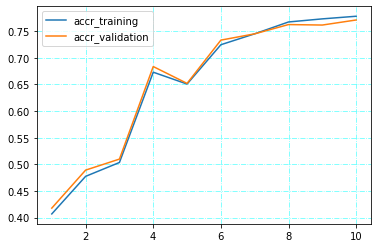

In [26]:

import numpy as np
import matplotlib.pyplot as plt
x = [i for i in range(1,11)]
line1, = plt.plot(x, acc_across_training, label='accr_training')
line2, = plt.plot(x, acc_across_validation, label='accr_validation')
#plt.plot(x, acc_with_epoch, label='accr')
plt.legend(handles=[line1, line2], loc='best')
plt.grid(b=True, color='aqua', alpha=0.6, linestyle='dashdot')
plt.show()

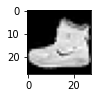

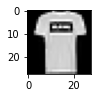

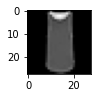

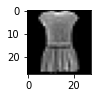

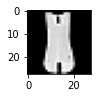

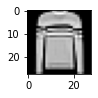

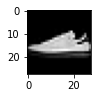

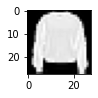

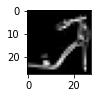

In [6]:
'''
from matplotlib import pyplot
for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()
'''

Number of Epoch = 1 - Average celoss:= 127.368525- Acc:= 0.16359998285770416 
Number of Epoch = 2 - Average celoss:= 115.234525- Acc:= 0.2609000504016876 
Number of Epoch = 3 - Average celoss:= 104.29383125- Acc:= 0.29909998178482056 
Number of Epoch = 4 - Average celoss:= 94.37913125- Acc:= 0.353200227022171 
Number of Epoch = 5 - Average celoss:= 85.4342125- Acc:= 0.3707001209259033 
Number of Epoch = 6 - Average celoss:= 77.34096875- Acc:= 0.383099764585495 
Number of Epoch = 7 - Average celoss:= 70.00730625- Acc:= 0.40989989042282104 
Number of Epoch = 8 - Average celoss:= 63.38885- Acc:= 0.41269969940185547 
Number of Epoch = 9 - Average celoss:= 57.3979125- Acc:= 0.4184001088142395 
Number of Epoch = 10 - Average celoss:= 51.973671875- Acc:= 0.42579975724220276 

Total time taken (in seconds): 205.89
